### Import Libraries

In [1]:
# Import fungsi time untuk mendapatkan nilai waktu mulai eksekusi
import time
a = time.time()
# Import fungsi matematika
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import fungsi Operating System Directory
import os
from __future__ import print_function, division
from builtins import range, input
# Install and/or Import TF dan Keras & show version
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
# Import Pre-trained Model VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# Import fungsi untuk Confusion Matrix dan Plot Grafik
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from glob import glob

Tensorflow version :  2.9.1
Keras version :  2.9.0


### Explore Data

In [ ]:
# Explore Dataset
# from random import shuffle

# Set to Current Working Directory
cwd = os.getcwd()
PATH = os.path.join(cwd, 'OCTOne-tenth')

# Set to train dir and show number of files
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (100, 100)

print('Training files and Classes')
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

print('Validation files and Classes')
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

#Split training set to 50%, 25%, or 10% for faster experimental training

#Show random training images
random = glob(train_dir + '/*/*.jp*g')
plt.imshow(keras.utils.load_img(np.random.choice(random)))
plt.show()

In [20]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Show random augmented images
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers
folders = glob(train_dir + '/*')
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

### Loss and Optimization functions

In [25]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [27]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = tf.keras.utils.image_dataset_from_directory(test_dataset, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
#for x, y in test_gen:
#    print("min:", x[0].min(), "max:", x[0].max())
#    plt.title(labels[np.argmax(y[0])])
#    plt.imshow(x[0])
#    plt.show()
#    break

TypeError: Unknown keywords argument(s): ('target_size',)

In [19]:
# training config:
epochs = 35

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/35


C:\Users\LABILK~1\AppData\Local\Temp/ipykernel_5332/1754378801.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


338/338 [==============================] - 225s 664ms/step - loss: 4.2162 - accuracy: 0.6470 - val_loss: 8.5510 - val_accuracy: 0.5312
Epoch 2/35
338/338 [==============================] - 223s 661ms/step - loss: 3.3108 - accuracy: 0.7106 - val_loss: 4.3111 - val_accuracy: 0.6149
Epoch 3/35
338/338 [==============================] - 223s 660ms/step - loss: 3.1275 - accuracy: 0.7346 - val_loss: 4.1104 - val_accuracy: 0.6472
Epoch 4/35
338/338 [==============================] - 224s 663ms/step - loss: 3.0040 - accuracy: 0.7442 - val_loss: 8.5707 - val_accuracy: 0.5726
Epoch 5/35
338/338 [==============================] - 226s 668ms/step - loss: 3.0310 - accuracy: 0.7505 - val_loss: 5.8172 - val_accuracy: 0.6089
Epoch 6/35
338/338 [==============================] - 226s 667ms/step - loss: 3.0413 - accuracy: 0.7511 - val_loss: 6.0622 - val_accuracy: 0.6109
Epoch 7/35
338/338 [==============================] - 224s 663ms/step - loss: 3.0021 - accuracy: 0.7569 - val_loss: 6.3933 - val_accura

In [20]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)




Generating confusion matrix 10829
Found 10829 images belonging to 4 classes.
2/2 [==============================] - 1s 565ms/step
50
2/2 [==============================] - 1s 565ms/step
100
2/2 [==============================] - 1s 563ms/step
150
1/1 [==============================] - 0s 315ms/step
[[3268  111  116  225]
 [ 153  564   36  381]
 [ 149   37  339  336]
 [ 196  184  189 4545]]
Generating confusion matrix 1000
Found 1000 images belonging to 4 classes.
2/2 [==============================] - 1s 151ms/step
[[227  14   1   8]
 [ 60 145   3  42]
 [ 74  19  46 111]
 [  9  16  11 214]]


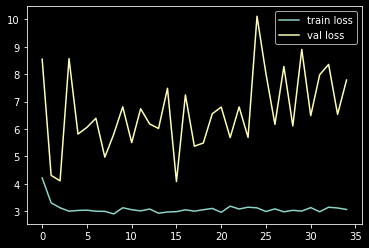

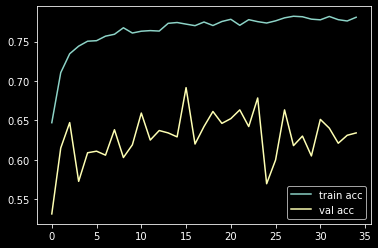

In [21]:
# plot Loss and Accuracies

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Confusion matrix, without normalization
[[3268  111  116  225]
 [ 153  564   36  381]
 [ 149   37  339  336]
 [ 196  184  189 4545]]


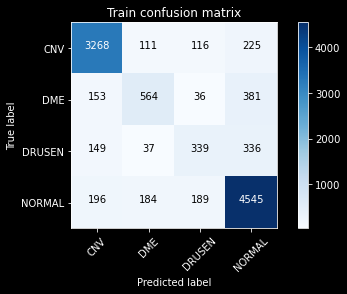

Confusion matrix, without normalization
[[227  14   1   8]
 [ 60 145   3  42]
 [ 74  19  46 111]
 [  9  16  11 214]]


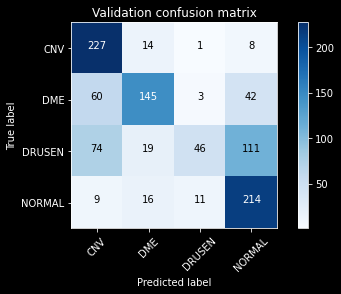

In [22]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [23]:
b = time.time()
print("time: ", b - a)

time:  8159.5495393276215
